In [1]:
import tensorflow as tf
print(tf.__version__)
import time
import cv2
from skimage import color
import os
from generator.u_net_generator_v2 import UNetGenerator
import matplotlib.pyplot as plt
# from source.preprocessing import *
import tensorflow_datasets as tfds
from discriminator.patch_resnet_discriminator import PatchResnetDiscriminator
from source.loss import disc_binary_cross_entropy, gen_l1_loss, gen_feature_matching, gen_binary_cross_entropy, disc_log_loss, \
  gen_log_loss, loss_hinge_dis, loss_hinge_gen

2.0.0-beta1


In [2]:
def preprocess_lab(lab):
    with tf.name_scope("preprocess_lab"):
        L_chan, a_chan, b_chan = tf.unstack(lab, axis=2)
        # L_chan: black and white with input range [0, 100]
        # a_chan/b_chan: color channels with input range ~[-110, 110], not exact
        # [0, 100] => [-1, 1],  ~[-110, 110] => [-1, 1]
        
        L_chan = L_chan / 50 - 1
        a_chan = a_chan / 110
        b_chan = b_chan / 110
        L_chan = tf.expand_dims(L_chan, axis=2)
        AB_chan = tf.stack([a_chan, b_chan], axis=2)
        return L_chan, AB_chan

In [3]:
def check_image(image):
    assertion = tf.assert_equal(tf.shape(image)[-1], 3, message="image must have 3 color channels")
    with tf.control_dependencies([assertion]):
        image = tf.identity(image)

    if image.get_shape().ndims not in (3, 4):
        raise ValueError("image must be either 3 or 4 dimensions")

    # make the last dimension 3 so that you can unstack the colors
    shape = list(image.get_shape())
    shape[-1] = 3
    image.set_shape(shape)
    return image

def rgb_to_lab(srgb):
    srgb = srgb / 255.
    with tf.name_scope("rgb_to_lab"):
        srgb = check_image(srgb)
        srgb_pixels = tf.reshape(srgb, [-1, 3])

        with tf.name_scope("srgb_to_xyz"):
            linear_mask = tf.cast(srgb_pixels <= 0.04045, dtype=tf.float32)
            exponential_mask = tf.cast(srgb_pixels > 0.04045, dtype=tf.float32)
            rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
            rgb_to_xyz = tf.constant([
                #    X        Y          Z
                [0.412453, 0.212671, 0.019334], # R
                [0.357580, 0.715160, 0.119193], # G
                [0.180423, 0.072169, 0.950227], # B
            ])
            xyz_pixels = tf.matmul(rgb_pixels, rgb_to_xyz)

        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope("xyz_to_cielab"):
            # convert to fx = f(X/Xn), fy = f(Y/Yn), fz = f(Z/Zn)

            # normalize for D65 white point
            xyz_normalized_pixels = tf.multiply(xyz_pixels, [1/0.950456, 1.0, 1/1.088754])

            epsilon = 6/29
            linear_mask = tf.cast(xyz_normalized_pixels <= (epsilon**3), dtype=tf.float32)
            exponential_mask = tf.cast(xyz_normalized_pixels > (epsilon**3), dtype=tf.float32)
            fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4/29) * linear_mask + (xyz_normalized_pixels ** (1/3)) * exponential_mask

            # convert to lab
            fxfyfz_to_lab = tf.constant([
                #  l       a       b
                [  0.0,  500.0,    0.0], # fx
                [116.0, -500.0,  200.0], # fy
                [  0.0,    0.0, -200.0], # fz
            ])
            lab_pixels = tf.matmul(fxfyfz_pixels, fxfyfz_to_lab) + tf.constant([-16.0, 0.0, 0.0])

        return tf.reshape(lab_pixels, tf.shape(srgb))

In [4]:
def deprocess_lab(L_chan, a_chan, b_chan):
    L_chan = tf.squeeze(L_chan)
    with tf.name_scope("deprocess_lab"):
        # this is axis=3 instead of axis=2 because we process individual images but deprocess batches
        return tf.stack([(L_chan + 1) / 2 * 100, a_chan * 110, b_chan * 110], axis=3)

def lab_to_rgb(lab):
    ## Input 4D Tensor - Batch of LAB images with range L=[0, 100], AB=[-110, 110]
    ## Output 4D Tensor: Batch of RGB images with range [0,1]
    with tf.name_scope("lab_to_rgb"):
        lab = check_image(lab)
        lab_pixels = tf.reshape(lab, [-1, 3])

        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope("cielab_to_xyz"):
            # convert to fxfyfz
            lab_to_fxfyfz = tf.constant([
                #   fx      fy        fz
                [1/116.0, 1/116.0,  1/116.0], # l
                [1/500.0,     0.0,      0.0], # a
                [    0.0,     0.0, -1/200.0], # b
            ])
            fxfyfz_pixels = tf.matmul(lab_pixels + tf.constant([16.0, 0.0, 0.0]), lab_to_fxfyfz)

            # convert to xyz
            epsilon = 6/29
            linear_mask = tf.cast(fxfyfz_pixels <= epsilon, dtype=tf.float32)
            exponential_mask = tf.cast(fxfyfz_pixels > epsilon, dtype=tf.float32)
            xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29)) * linear_mask + (fxfyfz_pixels ** 3) * exponential_mask

            # denormalize for D65 white point
            xyz_pixels = tf.multiply(xyz_pixels, [0.950456, 1.0, 1.088754])

        with tf.name_scope("xyz_to_srgb"):
            xyz_to_rgb = tf.constant([
                #     r           g          b
                [ 3.2404542, -0.9692660,  0.0556434], # x
                [-1.5371385,  1.8760108, -0.2040259], # y
                [-0.4985314,  0.0415560,  1.0572252], # z
            ])
            rgb_pixels = tf.matmul(xyz_pixels, xyz_to_rgb)
            # avoid a slightly negative number messing up the conversion
            rgb_pixels = tf.clip_by_value(rgb_pixels, 0.0, 1.0)
            linear_mask = tf.cast(rgb_pixels <= 0.0031308, dtype=tf.float32)
            exponential_mask = tf.cast(rgb_pixels > 0.0031308, dtype=tf.float32)
            srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + ((rgb_pixels ** (1/2.4) * 1.055) - 0.055) * exponential_mask

        return tf.reshape(srgb_pixels, tf.shape(lab))

In [5]:
IMG_SIZE = 384
PATCH_SIZE = 256
BATCH_SIZE = 16
BUFFER_SIZE = 64
EPOCHS=20

In [6]:
def random_resize(image):
  H, W = image.shape[:2]
  scale = tf.random.uniform([], minval=0.8, maxval=1.2, dtype=tf.float32, seed=None, name=None)
  shape = tf.stack((scale * W, scale * H), axis=0)
  shape = tf.cast(shape, tf.int32)
  image = tf.image.resize(image, size=shape)
  return image

def random_noise(input, target):
  bound = 1. / 128
  input += tf.random.uniform(shape=input.shape, minval=-bound, maxval=bound)
  return input, target

def process_tfds(features, HEIGHT, WIDTH):
  image = features["image"]
  image = tf.image.resize_with_crop_or_pad(image, target_height=HEIGHT, target_width=WIDTH)
  return tf.cast(image, tf.float32)

def random_crop(image, HEIGHT, WIDTH, CHANNELS=3):
  image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])
  return image

def random_flip(image):
  return tf.image.random_flip_left_right(image)

In [8]:
train_dataset = tfds.load(name="coco2014", split=tfds.Split.ALL)
train_dataset = train_dataset.map(lambda x: process_tfds(x, IMG_SIZE, IMG_SIZE))
train_dataset = train_dataset.map(random_resize)
train_dataset = train_dataset.map(lambda x: random_crop(x, PATCH_SIZE, PATCH_SIZE))
train_dataset = train_dataset.map(random_flip)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.shuffle(32)
train_dataset = train_dataset.batch(BATCH_SIZE)

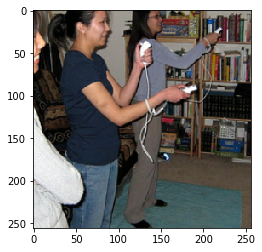

In [9]:
for rgb_image in train_dataset.take(1):
    plt.imshow(rgb_image[0]/255)
    plt.show()
    break

In [10]:
train_dataset = tfds.load(name="coco2014", split=tfds.Split.ALL)
train_dataset = train_dataset.map(lambda x: process_tfds(x, IMG_SIZE, IMG_SIZE))
train_dataset = train_dataset.map(random_resize)
train_dataset = train_dataset.map(lambda x: random_crop(x, PATCH_SIZE, PATCH_SIZE))
train_dataset = train_dataset.map(random_flip)
train_dataset = train_dataset.map(rgb_to_lab)
train_dataset = train_dataset.map(preprocess_lab)
train_dataset = train_dataset.repeat(1)
train_dataset = train_dataset.shuffle(32)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [11]:
# Hinge Loss
def loss_hinge_dis(dis_fake, dis_real):
  loss = tf.reduce_mean(tf.nn.relu(1. - dis_real))
  loss += tf.reduce_mean(tf.nn.relu(1. + dis_fake))
  return loss

def loss_hinge_gen(dis_fake):
  loss = -tf.reduce_mean(dis_fake)
  return loss

In [12]:
def batch_LAB_denorm(L_batch, AB_batch):
    assert np.min(L_batch) >= -1 and np.max(L_batch) <= 1, "L_batch must have range [-1,1]"
    assert np.min(AB_batch) >= -1 and np.max(AB_batch) <= 1, "AB_batch must have range [-1,1]"
    assert len(L_batch.shape) == 4, "L_batch image has to be 4D"
    assert len(AB_batch.shape) == 4, "AB_batch image has to be 4D"

    L_batch = (L_batch + 1) * 50
    L_batch = tf.clip_by_value(L_batch, 0, 100)

    AB_batch = AB_batch * 128
    A = AB_batch[..., 0:1]
    B = AB_batch[..., 1:]
    A = tf.clip_by_value(A, -127, 128)
    B = tf.clip_by_value(B, -128, 127)

    LAB_image = tf.concat([L_batch, A, B], axis=-1)
    return LAB_image

def batch_LAB2RGB(LAB_batch):
  # returns image in [0,1] interval
  assert len(LAB_batch.shape) == 4, "LAB_batch image has to be 4D"
  RGB_batch = np.zeros(LAB_batch.shape)
  for i in range(LAB_batch.shape[0]):
    RGB_batch[i] = color.lab2rgb(LAB_batch[i])
    
  assert np.min(RGB_batch) >= 0 and np.max(RGB_batch) <= 1, "batch_LAB2RGB should return RGB image with range [0,1]"
  return RGB_batch

input_image L shape: (16, 256, 256, 1)
input_image AB shape: (16, 256, 256, 2)
Channel L -1.0 1.0
Channel A -0.734853 0.61436903
Channel B -0.7334681 0.8323802
------------------------------- Generator And Discriminator RUN -------------------------------
Generator Image shape: (16, 256, 256, 2)


W0712 20:00:27.152482 140352105572096 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Patch size: (16, 31, 31, 1)
Generator Image (Range)
generator output range: -0.53274107 0.54222536
------------------------------- Fake LAB image -------------------------------
Channel L 0.0 100.0
Channel A -57.094326 59.64479
Channel B -58.601517 53.23112
------------------------------- Fake RGB image -------------------------------
Channel R 0.0 0.99999994
Channel G 0.0 0.99999994
Channel B 0.0 0.99999994
------------------------------- Reconstruct Original Image -------------------------------
real_lab_image range -80.83383 100.0
Gen Image L 0.0 100.0
Gen Image A -80.83383 67.5806
Gen Image B -80.681496 91.56182
real_rgb_image range 0.0 0.99999994
Gen Image R 0.0 0.9999971
Gen Image G 0.0 0.99999994
Gen Image B 0.0 0.9999644


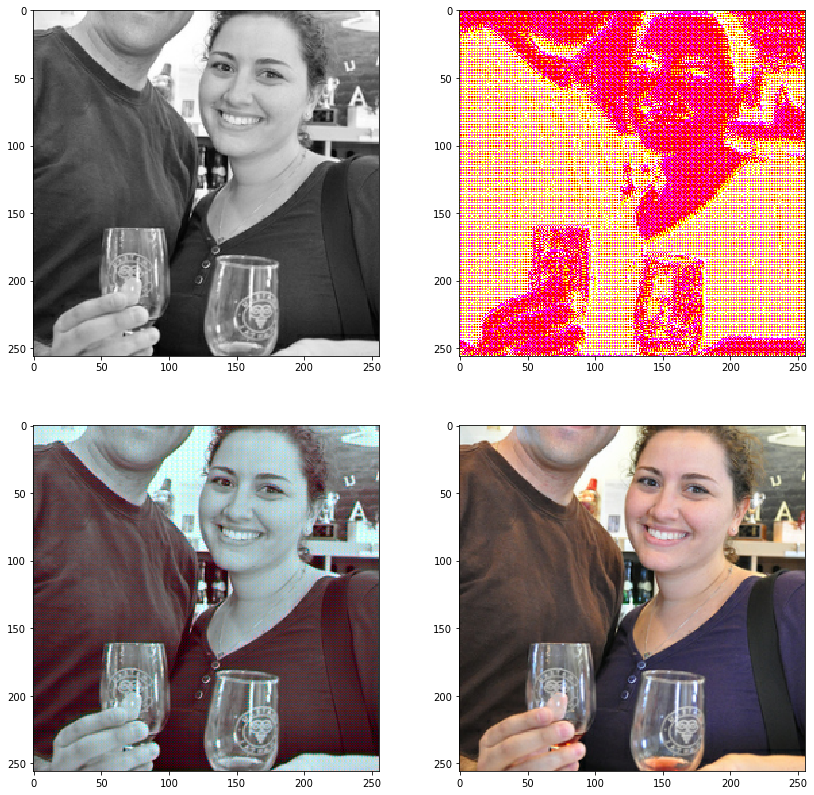

In [14]:
import matplotlib.pyplot as plt
import numpy as np

for L_batch, AB_batch in train_dataset.take(1):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,14), constrained_layout=False)
    
    print("input_image L shape:", L_batch.shape)    
    print("input_image AB shape:", AB_batch.shape)    
    print("Channel L", np.min(L_batch), np.max(L_batch))
    print("Channel A", np.min(AB_batch[...,0]), np.max(AB_batch[...,0]))
    print("Channel B", np.min(AB_batch[...,1]), np.max(AB_batch[...,1]))
    
    ax1.imshow(tf.squeeze((L_batch[0] + 1) * 0.5), cmap='gray')
    
    print("------------------------------- Generator And Discriminator RUN -------------------------------")
    generator = UNetGenerator(n_classes=2)
    discriminator = PatchResnetDiscriminator(ch=16)
    
    fake_image = generator(L_batch)
    print("Generator Image shape:", fake_image.shape)
  
    patch_real = discriminator(L_batch, AB_batch)
    patch_fake = discriminator(L_batch, fake_image)

    print("Patch size:", patch_fake.shape)
    print("Generator Image (Range)")
    print("generator output range:", np.min(fake_image), np.max(fake_image))
    
    a_chan_fake, b_chan_fake = tf.unstack(fake_image, axis=3)
    fake_lab_image = deprocess_lab(L_batch, a_chan_fake, b_chan_fake)
    print("------------------------------- Fake LAB image -------------------------------")
    print("Channel L", np.min(fake_lab_image[...,0]), np.max(fake_lab_image[...,0]))
    print("Channel A", np.min(fake_lab_image[...,1]), np.max(fake_lab_image[...,1]))
    print("Channel B", np.min(fake_lab_image[...,2]), np.max(fake_lab_image[...,2]))
    
    print("------------------------------- Fake RGB image -------------------------------")
    fake_rgb_image = lab_to_rgb(fake_lab_image)
    print("Channel R", np.min(fake_rgb_image[...,0]), np.max(fake_rgb_image[...,0]))
    print("Channel G", np.min(fake_rgb_image[...,1]), np.max(fake_rgb_image[...,1]))
    print("Channel B", np.min(fake_rgb_image[...,2]), np.max(fake_rgb_image[...,2]))
    ax2.imshow(fake_lab_image[0])
    ax3.imshow(fake_rgb_image[0])
        
    print("------------------------------- Reconstruct Original Image -------------------------------")
    a_chan, b_chan = tf.unstack(AB_batch, axis=3)
    real_lab_image = deprocess_lab(L_batch, a_chan, b_chan)
    
    print("real_lab_image range", np.min(real_lab_image), np.max(real_lab_image))
    print("Gen Image L", np.min(real_lab_image[...,0]), np.max(real_lab_image[...,0]))
    print("Gen Image A", np.min(real_lab_image[...,1]), np.max(real_lab_image[...,1]))
    print("Gen Image B", np.min(real_lab_image[...,2]), np.max(real_lab_image[...,2]))
     
    real_rgb_image = lab_to_rgb(real_lab_image)
    print("real_rgb_image range", np.min(real_rgb_image), np.max(real_rgb_image))

    print("Gen Image R", np.min(real_rgb_image[...,0]), np.max(real_rgb_image[...,0]))
    print("Gen Image G", np.min(real_rgb_image[...,1]), np.max(real_rgb_image[...,1]))
    print("Gen Image B", np.min(real_rgb_image[...,2]), np.max(real_rgb_image[...,2]))
    
    ax4.imshow(real_rgb_image[0])

#     ## Denormalize LAB Image
#     print("------------------------------- LAB Channels DeNormalize -------------------------------")
#     batch_lab_converted = batch_LAB_denorm(L_batch, AB_batch)
#     print("Channel L", np.min(batch_lab_converted[...,0]), np.max(batch_lab_converted[...,0]))
#     print("Channel A", np.min(batch_lab_converted[...,1]), np.max(batch_lab_converted[...,1]))
#     print("Channel B", np.min(batch_lab_converted[...,2]), np.max(batch_lab_converted[...,2]))
#     ax2.imshow(tf.squeeze((batch_lab_converted[0] + 1) * 0.5), cmap='gray')
#     # Convert it back to RGB
#     print("------------------------------- LAB to RGB -------------------------------")
    
#     print("batch_lab_converted.shape:", batch_lab_converted.shape)
#     batch_rgb_converted = batch_LAB2RGB(batch_lab_converted)
    
#     print("Batch RGB Converted")
#     print("Channel R", np.min(batch_rgb_converted[...,0]), np.max(batch_rgb_converted[...,0]))
#     print("Channel G", np.min(batch_rgb_converted[...,1]), np.max(batch_rgb_converted[...,1]))
#     print("Channel B", np.min(batch_rgb_converted[...,2]), np.max(batch_rgb_converted[...,2]))
    
#     ax3.imshow(batch_rgb_converted[0])
plt.show()